In [50]:
from numpy import load
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K

In [2]:
#Loading arrays from disk
def load_arrays(pathx, pathy):
    dict_data_x = load(pathx)
    dict_data_y = load(pathy)
    x = dict_data_x['arr_0']
    y = dict_data_y['arr_0']
    return x, y

In [240]:
#Function for plotting training afterwards
def plot_training(H):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    #plt.plot(H.history["accuracy"], label="train_acc")
    #plt.plot(H.history["val_accuracy"], label="val_acc")
    #plt.title("Training Loss and Accuracy")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    #plt.ylabel("Loss/Accuracy")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

In [4]:
#Function for loading and preprocessing data
def load_and_preprocess(path_to_features, path_to_labels, test_size):
    #load data
    x, y, = load_arrays(path_to_features, path_to_labels)
    #split data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    #get the data between 0 and 1
    x_train = x_train / 255.
    x_test = x_test / 255.
    #print shapes of the data
    print(f"x_train: {x_train.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"x_test: {x_test.shape}")
    print(f"y_test: {y_test.shape}")
    
    return x_train, x_test, y_train, y_test

In [249]:
#Function for computing accuracy
def compute_accuracy(predictions, labels):
    #compute the mean of the distances
    return labels[predictions.ravel() < 0.5].mean()

In [5]:
#Function for calculating the euclidian distance between the output feature vectors
#def euclidian_distance(vects):
#    x, y = vects
#    distance = K.sqrt(K.sum(K.square(x-y), axis=1, keepdims=True))
#    return distance

In [412]:
def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [6]:
x_train, x_test, y_train, y_test = load_and_preprocess("data_3000_samples/data_x_3000.npz", "data_3000_samples/data_y_3000.npz", 0.25)

x_train: (4500, 2, 150, 150, 1)
y_train: (4500, 1)
x_test: (1500, 2, 150, 150, 1)
y_test: (1500, 1)


In [556]:
#Build base model 1
tf.random.set_seed(42)

inputs = keras.layers.Input(x_train.shape[2:])

x = keras.layers.Conv2D(16, (3,3), activation="relu")(inputs)
x = keras.layers.MaxPool2D(3,3)(x)
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(48, activation="relu")(x)

base_model_1 = keras.models.Model(inputs, outputs)

In [557]:
base_model_1.summary()

Model: "model_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_84 (InputLayer)        [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 148, 148, 16)      160       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 49, 49, 16)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 49, 49, 16)        0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 38416)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 48)                1844016   
Total params: 1,844,176
Trainable params: 1,844,176
Non-trainable params: 0
________________________________________________

In [558]:
#define inputs and outputs
img_a = keras.layers.Input(shape=x_train.shape[2:])
img_b = keras.layers.Input(shape=x_train.shape[2:])
feat_vec_a = base_model_1(img_a)
feat_vec_b = base_model_1(img_b)
distance = keras.layers.Lambda(euclidian_distance)([feat_vec_a, feat_vec_b])

In [559]:
#def contrastive_loss(y_true, y_pred):
#    margin = 1
#    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [560]:
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    return loss

In [561]:
#Build and compile the model
model_1 = keras.models.Model(inputs=[img_a, img_b], outputs=distance)
model_1.compile(loss=contrastive_loss, optimizer="Adam")

In [562]:
history_model_1=model_1.fit([x_train[:, 0], x_train[:, 1]], y_train, validation_data=([x_test[:, 0], x_test[:, 1]], y_test), epochs=20, batch_size=128, verbose=0)

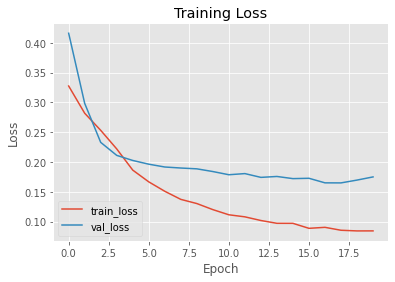

In [563]:
plot_training(history_model_1)

In [564]:
y_pred_model_1 = model_1.predict([x_test[:, 0], x_test[:, 1]])

In [565]:
compute_accuracy(y_pred_model_1, y_test)

0.7657657657657657

In [566]:
from PIL import Image, ImageOps
def read_image(filename, width, height):
    #read image and get size
    image = Image.open(filename)
    
    #convert image to grayscale
    gray = ImageOps.grayscale(image)
    
    #resize the image
    resize = gray.resize((width, height), Image.ANTIALIAS)
    
    #convert grayscale image to numpy array
    im_array = np.array(resize)

    return(im_array)

In [567]:
im_1_path = "testset/lines/0052/0052-1-0.tif"
im_2_path = "testset/lines/0052/0052-1-1.tif"
im_3_path = "testset/lines/0053/0053-1-0.tif"
im_4_path = "testset/lines/0053/0053-1-1.tif"

In [568]:
im_1 = read_image(im_1_path, 150, 150)
im_2 = read_image(im_2_path, 150, 150)
im_3 = read_image(im_3_path, 150, 150)
im_4 = read_image(im_4_path, 150, 150)

In [569]:
im_1 = im_1 / 255.
im_2 = im_2 / 255.
im_3 = im_3 / 255.
im_4 = im_4 / 255.

In [570]:
im_1 = np.expand_dims(im_1, axis=0)
im_2 = np.expand_dims(im_2, axis=0)
im_3 = np.expand_dims(im_3, axis=0)
im_4 = np.expand_dims(im_4, axis=0)

In [571]:
model_1.predict([im_1, im_2])

array([[1.1391553]], dtype=float32)

In [572]:
model_1.predict([im_3, im_4])

array([[0.9240499]], dtype=float32)

In [573]:
model_1.predict([im_1, im_3])

array([[0.4562663]], dtype=float32)